In [17]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


torch.manual_seed(111)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Code will run on {device}")

Code will run on cpu


In [34]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5,), (0.5,))
     ]
    )

batch_size = 32
train_data_dir = "/content/drive/MyDrive/capybaras/capybaras_resized"

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.data_dir = dir
        self.images = os.listdir(dir)
        self.transform = transform

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.images[index])
        image = np.array(Image.open(image_path).convert("RGB"))

        # Applying the transform
        if self.transform:
            image = self.transform(image)

        return image

In [35]:
dataset = ImageDataset(train_data_dir, transform=transform)

tensor([[[-0.6017, -0.6645, -0.7328,  ..., -0.3098, -0.2336, -0.2132],
         [-0.6488, -0.6880, -0.7350,  ..., -0.3098, -0.2728, -0.2603],
         [-0.7086, -0.7087, -0.7350,  ..., -0.3273, -0.3170, -0.3014],
         ...,
         [-0.1293, -0.1719, -0.2043,  ..., -0.4903, -0.5143, -0.5770],
         [-0.1557, -0.1376, -0.1064,  ..., -0.5530, -0.5927, -0.6624],
         [-0.1904, -0.1141, -0.0358,  ..., -0.5816, -0.6319, -0.6902]]])


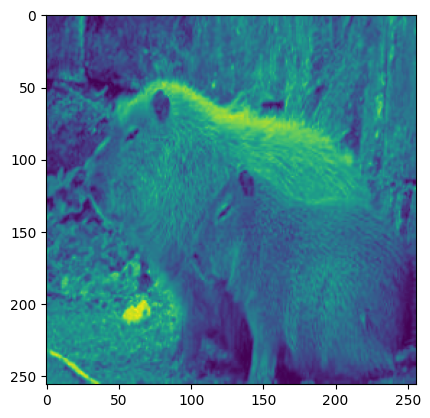

In [36]:
print(dataset[6])
plt.imshow(dataset[6].squeeze())  # ВАЖНО, восстанавливает изображение из тензора
plt.show()

In [37]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [38]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 8192),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 65536)
        output = self.model(x)
        return output

In [39]:
discriminator = Discriminator().to(device=device)

In [40]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 8192),
            nn.ReLU(),
            nn.Linear(8192, 65536),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 256, 256)
        return output

generator = Generator().to(device=device)

In [41]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [42]:
for n, real_samples in enumerate(train_loader):
  print(real_samples.shape)

torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8,

In [43]:
for epoch in range(num_epochs):
    for n, real_samples in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.3290507197380066
Epoch: 0 Loss G.: 1.0964837074279785
Epoch: 1 Loss D.: 0.5567893981933594
Epoch: 1 Loss G.: 0.8308177590370178
Epoch: 2 Loss D.: 0.23182852566242218
Epoch: 2 Loss G.: 0.9882274270057678
Epoch: 3 Loss D.: 0.3933946490287781
Epoch: 3 Loss G.: 1.052364468574524
Epoch: 4 Loss D.: 0.38137730956077576
Epoch: 4 Loss G.: 1.1971290111541748


KeyboardInterrupt: 